In [1]:
from __future__ import print_function
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

import ROOT
%jsroot on
# from ROOT import TCanvas, TH1F, TH2F, TF1, TMath, TGraph, TFile, TSpectrum, TPaveText, TMultiGraph, TGraphErrors, TLine
from ROOT import gStyle, gROOT, gDirectory, gPad

import constants
import crv_event
import crv_spill
import utils
import geometry
import geometry_constants
import filepath

gROOT.Reset()
gROOT.SetBatch(1)
gROOT.ProcessLine( "gErrorIgnoreLevel = 1001;")
gStyle.SetOptStat(111110)
gStyle.SetOptFit(0)
gStyle.SetLineScalePS(0.3)

tgeometry = geometry.testBenchGeometry(geometry_constants.setup_dict['crvaging-006'][0])

offsetFileList = filepath.getfilelist(["1380"])[0]
refFileList = filepath.getfilelist(["1379"])[0]

Welcome to JupyROOT 6.28/04


In [2]:
# check PE sum, see where to cut for "shower"

pdfpages = PdfPages("timingAlignmentFEB_phaseAligned_exampleShower.pdf")

fFile = ROOT.TFile(refFileList[0], "READ")
fTree = fFile.Get("run")

hist_sum_tot = ROOT.TH1F("hist_sum_tot", "Total light yield per event; n_{PE}; count", 500, 0., 10000.)
hist_sum_feb = [None]*6
hist_sum_tot_goodfit = ROOT.TH1F("hist_sum_tot_goodfit", "Total light yield per event; n_{PE}; count", 500, 0., 10000.)
hist_sum_feb_goodfit = [None]*6
for i in range(6):
    hist_sum_feb[i] = ROOT.TH1F("hist_sum_feb_%i"%i, "Light yield sum per FEB; n_{PE}; count", 500, 0., 2000.)
    hist_sum_feb_goodfit[i] = ROOT.TH1F("hist_sum_feb_%i_goodfit"%i, "Light yield sum per FEB; n_{PE}; count", 500, 0., 2000.)

nplot = 0
nEntries = fTree.GetEntries()
for iEntry in range(nEntries):
    if iEntry % 10000 == 0:
        print("processed %i/%i entries..."%(iEntry, nEntries))
    tEvent = crv_event.crv_event(fTree, iEntry, 0b1010, 6)
    tFEBsum = np.sum(tEvent.PEsTemperatureCorrected, axis=1)
    tTOTsum = np.sum(tFEBsum)
    tFEBsum_goodfit = np.array([np.sum(tEvent.PEsTemperatureCorrected[i][tEvent.fitStatus[i]==1]) for i in range(6)])
    tTOTsum_goodfit = np.sum(tFEBsum_goodfit)
    hist_sum_tot.Fill(tTOTsum)
    hist_sum_tot_goodfit.Fill(tTOTsum_goodfit)
    for i in range(6):
        hist_sum_feb[i].Fill(tFEBsum[i])
        hist_sum_feb_goodfit[i].Fill(tFEBsum_goodfit[i])
    # if tTOTsum_goodfit > 3000 and nplot < 20:
    if np.all(tFEBsum>300) and nplot < 20:
        tEvent.plotEvent(pdfpages, [tgeometry], True)
        nplot += 1

pdfpages.close()
from IPython.display import IFrame
IFrame("timingAlignmentFEB_phaseAligned_exampleShower.pdf", width=800, height=600)

processed 0/230513 entries...


/cvmfs/mu2e.opensciencegrid.org/artexternals/pyana/v1_03_00/Linux64bit+3.10-2.17/lib/python3.9/site-packages/matplotlib/collections.py:967: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


processed 10000/230513 entries...
processed 20000/230513 entries...
processed 30000/230513 entries...
processed 40000/230513 entries...
processed 50000/230513 entries...
processed 60000/230513 entries...
processed 70000/230513 entries...
processed 80000/230513 entries...
processed 90000/230513 entries...
processed 100000/230513 entries...
processed 110000/230513 entries...
processed 120000/230513 entries...
processed 130000/230513 entries...
processed 140000/230513 entries...
processed 150000/230513 entries...
processed 160000/230513 entries...
processed 170000/230513 entries...
processed 180000/230513 entries...
processed 190000/230513 entries...
processed 200000/230513 entries...
processed 210000/230513 entries...
processed 220000/230513 entries...
processed 230000/230513 entries...


In [3]:
c1 = ROOT.TCanvas("c1", "c1", 900, 400)
c1.SetLogy()
hist_sum_tot.Draw()
c1.Draw()

In [4]:
hist_sum_tot_goodfit.Draw()
c1.Draw()

In [5]:
c2 = ROOT.TCanvas("c2", "c2", 900, 400)
gStyle.SetOptStat(0)
c2.SetLogy()
fLegend = ROOT.TLegend(0.75, 0.6, 0.9, 0.9)
for i in range(6):
    hist_sum_feb[i].SetLineColor(constants.rootcolors[i])
    hist_sum_feb[i].Draw("SAME" if i > 0 else "")
    fLegend.AddEntry(hist_sum_feb[i], "FEB%i"%i)
fLegend.Draw("SAME")
c2.Draw()

In [6]:
fLegend = ROOT.TLegend(0.75, 0.6, 0.9, 0.9)
for i in range(6):
    hist_sum_feb_goodfit[i].SetLineColor(constants.rootcolors[i])
    hist_sum_feb_goodfit[i].Draw("SAME" if i > 0 else "")
    fLegend.AddEntry(hist_sum_feb_goodfit[i], "FEB%i"%i)
fLegend.Draw("SAME")
c2.Draw()

In [7]:
fFile.Close()

In [8]:
gROOT.Reset()
gStyle.SetOptStat(0)
gStyle.SetOptFit(0)
gStyle.SetLineScalePS(0.3)

tmin = 900.
tmax = 1100.
nbin = 200
showerthres = 1800
singleFEBshowerthres = 300

def plotTimeMean(filelist, tag):
    hist_tmean = [None]*6
    hist_tmeanwtd = [None]*6
    hist_tmeanthresh = [None]*6
    hist_tmeanthreshwtd = [None]*6
    for i in range(6):
        hist_tmean[i] = ROOT.TH1F("hist_tmean_%s_feb%i"%(tag,i), "Average Hit Time (%s); t_{avg} [ns]; count"%tag, nbin, tmin, tmax)
        hist_tmeanwtd[i] = ROOT.TH1F("hist_tmeanwtd_%s_feb%i"%(tag,i), "Weighted Average Hit Time (%s); t_{avg} [ns]; count"%tag, nbin, tmin, tmax)
        hist_tmeanthresh[i] = ROOT.TH1F("hist_tmeanthresh_%s_feb%i"%(tag,i), "Average Hit Time over 6PE Threshold (%s); t_{avg} [ns]; count"%tag, nbin, tmin, tmax)
        hist_tmeanthreshwtd[i] = ROOT.TH1F("hist_tmeanthreshwtd_%s_feb%i"%(tag,i), "Weighted Average Hit Time over 6PE Threshold (%s); t_{avg} [ns]; count"%tag, nbin, tmin, tmax)
        
    for filename in filelist:
        print("Processing file %s"%(filename.split('/')[-1]))
        fFile = ROOT.TFile(filename, "READ")
        fTree = fFile.Get("run")
        nEntries = fTree.GetEntries()
        for iEntry in range(nEntries):
            if iEntry % 10000 == 0:            
                print("processed %i/%i entries..."%(iEntry, nEntries))            
            tEvent = crv_event.crv_event(fTree, iEntry, 0b1010, 6)
            tgoodhitPE = [tEvent.PEsTemperatureCorrected[i][tEvent.fitStatus[i]==1] for i in range(6)]
            tTOTsum_goodfit = sum([np.sum(tgoodhitPE[i]) for i in range(6)])
            # if tTOTsum_goodfit>showerthres:
            if np.all(np.array([np.sum(tgoodhitPE[i]) for i in range(6)])>singleFEBshowerthres):
                tgoodhittime = [tEvent.time[i][tEvent.fitStatus[i]==1] for i in range(6)]
                t_tmean = [np.mean(tgoodhittime[i]) if np.any(tgoodhittime[i]) else None for i in range(6)]
                t_tmeanwtd = [np.sum(tgoodhitPE[i]*tgoodhittime[i])/np.sum(tgoodhitPE[i]) if np.any(tgoodhittime[i]) else None for i in range(6)]

                tgoodhitPE_overthresh = [tgoodhitPE[i][tgoodhitPE[i]>6.] for i in range(6)]
                tgoodhittime_overthresh = [tgoodhittime[i][tgoodhitPE[i]>6.] for i in range(6)]
                t_tmeanthresh = [np.mean(tgoodhittime_overthresh[i]) if np.any(tgoodhittime_overthresh[i]) else None for i in range(6)]
                t_tmeanthreshwtd = [np.sum(tgoodhitPE_overthresh[i]*tgoodhittime_overthresh[i])/np.sum(tgoodhitPE_overthresh[i]) if np.any(tgoodhittime_overthresh[i]) else None for i in range(6)]

                for i in range(6):
                    if t_tmean[i]:
                        hist_tmean[i].Fill(t_tmean[i])
                    if t_tmeanwtd[i]:
                        hist_tmeanwtd[i].Fill(t_tmeanwtd[i])
                    if t_tmeanthresh[i]:
                        hist_tmeanthresh[i].Fill(t_tmeanthresh[i])
                    if t_tmeanthreshwtd[i]:
                        hist_tmeanthreshwtd[i].Fill(t_tmeanthreshwtd[i])

        fFile.Close()
    
    func = [[None]*6 for i in range(4)]
    
    # c01 = ROOT.TCanvas("c01", "c01", 900, 400)
    print("----- Plain Mean Time -----")
    fLegend1 = ROOT.TLegend(0.8, 0.6, 0.9, 0.9)
    fStack1 = ROOT.THStack("stack_tmean_%s"%(tag), "Average Hit Time (%s); t_{avg} [ns]; count"%tag)
    fitmean = []
    fitmean_err = []
    fitrms = []
    fitrms_err = []
    for i in range(6):
        func[0][i] = ROOT.TF1("func_%s_tmean_FEB%i"%(tag, i), "[0]*TMath::Gaus(x,[1],[2])",tmin,tmax)
        func[0][i].SetParameter(0,hist_tmean[i].GetEntries()/2.5/hist_tmean[i].GetRMS())
        func[0][i].SetParameter(1,hist_tmean[i].GetMean())
        func[0][i].SetParameter(2,hist_tmean[i].GetRMS()/2.)
        func[0][i].SetParName(0, "A")
        func[0][i].SetParName(1, "#mu")
        func[0][i].SetParName(2, "#sigma")
        func[0][i].SetParLimits(1, hist_tmean[i].GetMean()-2.*hist_tmean[i].GetRMS(), hist_tmean[i].GetMean()+2.*hist_tmean[i].GetRMS())
        func[0][i].SetParLimits(2, .005, 200)
        fitoption = "QRS"
        if hist_tmean[i].GetEntries() < 2000:
            fitoption+="L"
        fitmin = hist_tmean[i].GetMean()-2.*hist_tmean[i].GetRMS()
        fitmax = hist_tmean[i].GetMean()+2.*hist_tmean[i].GetRMS()
        frp = hist_tmean[i].Fit(func[0][i],fitoption,"",fitmin,fitmax)      
        fitmean.append(func[0][i].GetParameter(1))
        fitmean_err.append(func[0][i].GetParError(1))
        fitrms.append(func[0][i].GetParameter(2))
        fitrms_err.append(func[0][i].GetParError(2))
              
        hist_tmean[i].SetLineColor(constants.rootcolors[i])
        fStack1.Add(hist_tmean[i])
        func[0][i].SetLineColor(constants.rootcolors[i])
        
        fLegend1.AddEntry(hist_tmean[i], "FEB%i"%i)
    # fStack1.Draw("NOSTACK")
    # for i in range(6):
        # func[0][i].DrawClone("SAME")
    # fLegend1.Draw("SAME")
    print("fit mean", fitmean)
    print("     +/-", fitmean_err)
    print("fit  rms", fitrms)
    print("     +/-", fitrms_err)
    
    # c02 = ROOT.TCanvas("c02", "c02", 900, 400)
    print("----- Weighted Time -----")
    fLegend2 = ROOT.TLegend(0.8, 0.6, 0.9, 0.9)
    fStack2 = ROOT.THStack("stack_tmeanwtd_%s"%(tag), "Weighted Average Hit Time (%s); t_{avg} [ns]; count"%tag)
    fitmean = []
    fitmean_err = []
    fitrms = []
    fitrms_err = []
    for i in range(6):
        func[1][i] = ROOT.TF1("func_%s_tmeanwtd_FEB%i"%(tag, i), "[0]*TMath::Gaus(x,[1],[2])",tmin,tmax)
        func[1][i].SetParameter(0,hist_tmeanwtd[i].GetEntries()/2.5/hist_tmean[i].GetRMS())
        func[1][i].SetParameter(1,hist_tmeanwtd[i].GetMean())
        func[1][i].SetParameter(2,hist_tmeanwtd[i].GetRMS()/2.)
        func[1][i].SetParName(0, "A")
        func[1][i].SetParName(1, "#mu")
        func[1][i].SetParName(2, "#sigma")
        func[1][i].SetParLimits(1, hist_tmeanwtd[i].GetMean()-2.*hist_tmeanwtd[i].GetRMS(), hist_tmeanwtd[i].GetMean()+2.*hist_tmeanwtd[i].GetRMS())
        func[1][i].SetParLimits(2, .005, 200)
        fitoption = "QRS"
        if hist_tmeanwtd[i].GetEntries() < 2000:
            fitoption+="L"
        fitmin = hist_tmeanwtd[i].GetMean()-2.*hist_tmeanwtd[i].GetRMS()
        fitmax = hist_tmeanwtd[i].GetMean()+2.*hist_tmeanwtd[i].GetRMS()
        frp = hist_tmeanwtd[i].Fit(func[1][i],fitoption,"",fitmin,fitmax)      
        fitmean.append(func[1][i].GetParameter(1))
        fitmean_err.append(func[1][i].GetParError(1))
        fitrms.append(func[1][i].GetParameter(2))
        fitrms_err.append(func[1][i].GetParError(2))
              
        hist_tmeanwtd[i].SetLineColor(constants.rootcolors[i])
        fStack2.Add(hist_tmeanwtd[i])
        func[1][i].SetLineColor(constants.rootcolors[i])
        
        fLegend2.AddEntry(hist_tmeanwtd[i], "FEB%i"%i)
    # fStack2.Draw("NOSTACK")
    # for i in range(6):
        # func[1][i].DrawClone("SAME")
    # fLegend2.Draw("SAME")
    print("fit mean", fitmean)
    print("     +/-", fitmean_err)
    print("fit  rms", fitrms)
    print("     +/-", fitrms_err)
          
    # c03 = ROOT.TCanvas("c03", "c03", 900, 400)
    print("----- Mean Time Over Threshold -----")
    fLegend3 = ROOT.TLegend(0.8, 0.6, 0.9, 0.9)
    fStack3 = ROOT.THStack("stack_tmeanthresh_%s"%(tag), "Average Hit Time over 6PE Threshold (%s); t_{avg} [ns]; count"%tag)
    fitmean = []
    fitmean_err = []
    fitrms = []
    fitrms_err = []
    for i in range(6):
        func[2][i] = ROOT.TF1("func_%s_tmeanthresh_FEB%i"%(tag, i), "[0]*TMath::Gaus(x,[1],[2])",tmin,tmax)
        func[2][i].SetParameter(0,hist_tmeanthresh[i].GetEntries()/2.5/hist_tmean[i].GetRMS())
        func[2][i].SetParameter(1,hist_tmeanthresh[i].GetMean())
        func[2][i].SetParameter(2,hist_tmeanthresh[i].GetRMS()/2.)
        func[2][i].SetParName(0, "A")
        func[2][i].SetParName(1, "#mu")
        func[2][i].SetParName(2, "#sigma")
        func[2][i].SetParLimits(1, hist_tmeanthresh[i].GetMean()-2.*hist_tmeanthresh[i].GetRMS(), hist_tmeanthresh[i].GetMean()+2.*hist_tmeanthresh[i].GetRMS())
        func[2][i].SetParLimits(2, .005, 200)
        fitoption = "QRS"
        if hist_tmeanthresh[i].GetEntries() < 2000:
            fitoption+="L"
        fitmin = hist_tmeanthresh[i].GetMean()-2.*hist_tmeanthresh[i].GetRMS()
        fitmax = hist_tmeanthresh[i].GetMean()+2.*hist_tmeanthresh[i].GetRMS()
        frp = hist_tmeanthresh[i].Fit(func[2][i],fitoption,"",fitmin,fitmax)      
        fitmean.append(func[2][i].GetParameter(1))
        fitmean_err.append(func[2][i].GetParError(1))
        fitrms.append(func[2][i].GetParameter(2))
        fitrms_err.append(func[2][i].GetParError(2))
              
        hist_tmeanthresh[i].SetLineColor(constants.rootcolors[i])
        fStack3.Add(hist_tmeanthresh[i])
        func[2][i].SetLineColor(constants.rootcolors[i])
        
        fLegend3.AddEntry(hist_tmeanthresh[i], "FEB%i"%i)
    # fStack3.Draw("NOSTACK")
    # for i in range(6):
        # func[2][i].DrawClone("SAME")
    # fLegend3.Draw("SAME")
    print("fit mean", fitmean)
    print("     +/-", fitmean_err)
    print("fit  rms", fitrms)
    print("     +/-", fitrms_err)
              
    # c04 = ROOT.TCanvas("c04", "c04", 900, 400)
    print("----- Weighted Time Over Threshold-----")
    fLegend4 = ROOT.TLegend(0.8, 0.6, 0.9, 0.9)
    fStack4 = ROOT.THStack("stack_tmeanthreshwtd_%s"%(tag), "Weighted Average Hit Time over 6PE Threshold (%s); t_{avg} [ns]; count"%tag)
    fitmean = []
    fitmean_err = []
    fitrms = []
    fitrms_err = []
    for i in range(6):
        func[3][i] = ROOT.TF1("func_%s_tmeanthreshwtd_FEB%i"%(tag, i), "[0]*TMath::Gaus(x,[1],[2])",tmin,tmax)
        func[3][i].SetParameter(0,hist_tmeanthreshwtd[i].GetEntries()/2.5/hist_tmean[i].GetRMS())
        func[3][i].SetParameter(1,hist_tmeanthreshwtd[i].GetMean())
        func[3][i].SetParameter(2,hist_tmeanthreshwtd[i].GetRMS()/2.)
        func[3][i].SetParName(0, "A")
        func[3][i].SetParName(1, "#mu")
        func[3][i].SetParName(2, "#sigma")
        func[3][i].SetParLimits(1, hist_tmeanthreshwtd[i].GetMean()-2.*hist_tmeanthreshwtd[i].GetRMS(), hist_tmeanthreshwtd[i].GetMean()+2.*hist_tmeanthreshwtd[i].GetRMS())
        func[3][i].SetParLimits(2, .005, 200)
        fitoption = "QRS"
        if hist_tmeanthreshwtd[i].GetEntries() < 2000:
            fitoption+="L"
        fitmin = hist_tmeanthreshwtd[i].GetMean()-2.*hist_tmeanthreshwtd[i].GetRMS()
        fitmax = hist_tmeanthreshwtd[i].GetMean()+2.*hist_tmeanthreshwtd[i].GetRMS()
        frp = hist_tmeanthreshwtd[i].Fit(func[3][i],fitoption,"",fitmin,fitmax)      
        fitmean.append(func[3][i].GetParameter(1))
        fitmean_err.append(func[3][i].GetParError(1))
        fitrms.append(func[3][i].GetParameter(2))
        fitrms_err.append(func[3][i].GetParError(2))
              
        hist_tmeanthreshwtd[i].SetLineColor(constants.rootcolors[i])
        fStack4.Add(hist_tmeanthreshwtd[i])
        func[3][i].SetLineColor(constants.rootcolors[i])
        
        fLegend4.AddEntry(hist_tmeanthreshwtd[i], "FEB%i"%i)
    # fStack4.Draw("NOSTACK")
    # for i in range(6):
        # func[3][i].DrawClone("SAME")
    # fLegend4.Draw("SAME")
    print("fit mean", fitmean)
    print("     +/-", fitmean_err)
    print("fit  rms", fitrms)
    print("     +/-", fitrms_err)
    
    return [fStack1, fStack2, fStack3, fStack4], func, [fLegend1, fLegend2, fLegend3, fLegend4]

In [9]:
stacks_offset, func_offset, legend_offset = plotTimeMean(offsetFileList, "offset")

Processing file rec.mu2e.CRV_wideband_cosmics.CRVWB-000-001-000.001380_000.root
processed 0/241118 entries...
processed 10000/241118 entries...
processed 20000/241118 entries...
processed 30000/241118 entries...
processed 40000/241118 entries...
processed 50000/241118 entries...
processed 60000/241118 entries...
processed 70000/241118 entries...
processed 80000/241118 entries...
processed 90000/241118 entries...
processed 100000/241118 entries...
processed 110000/241118 entries...
processed 120000/241118 entries...
processed 130000/241118 entries...
processed 140000/241118 entries...
processed 150000/241118 entries...
processed 160000/241118 entries...
processed 170000/241118 entries...
processed 180000/241118 entries...
processed 190000/241118 entries...
processed 200000/241118 entries...
processed 210000/241118 entries...
processed 220000/241118 entries...
processed 230000/241118 entries...
processed 240000/241118 entries...
----- Plain Mean Time -----
fit mean [963.5260324060645, 97

In [10]:
c01 = ROOT.TCanvas("c01", "c01", 900, 400)
stacks_offset[0].Draw("NOSTACK")
for i in range(6):
    func_offset[0][i].DrawClone("SAME")
legend_offset[0].Draw("SAME")
c01.Draw()

In [11]:
c02 = ROOT.TCanvas("c02", "c02", 900, 400)
stacks_offset[1].Draw("NOSTACK")
for i in range(6):
    func_offset[1][i].DrawClone("SAME")
legend_offset[1].Draw("SAME")
c02.Draw()

In [12]:
c03 = ROOT.TCanvas("c03", "c03", 900, 400)
stacks_offset[2].Draw("NOSTACK")
for i in range(6):
    func_offset[2][i].DrawClone("SAME")
legend_offset[2].Draw("SAME")
c03.Draw()

In [13]:
c04 = ROOT.TCanvas("c04", "c04", 900, 400)
stacks_offset[3].Draw("NOSTACK")
for i in range(6):
    func_offset[3][i].DrawClone("SAME")
legend_offset[3].Draw("SAME")
c04.Draw()

In [14]:
stacks_ref, func_ref, legend_ref = plotTimeMean(refFileList, "reference")

Processing file rec.mu2e.CRV_wideband_cosmics.CRVWB-000-001-000.001379_000.root
processed 0/230513 entries...
processed 10000/230513 entries...
processed 20000/230513 entries...
processed 30000/230513 entries...
processed 40000/230513 entries...
processed 50000/230513 entries...
processed 60000/230513 entries...
processed 70000/230513 entries...
processed 80000/230513 entries...
processed 90000/230513 entries...
processed 100000/230513 entries...
processed 110000/230513 entries...
processed 120000/230513 entries...
processed 130000/230513 entries...
processed 140000/230513 entries...
processed 150000/230513 entries...
processed 160000/230513 entries...
processed 170000/230513 entries...
processed 180000/230513 entries...
processed 190000/230513 entries...
processed 200000/230513 entries...
processed 210000/230513 entries...
processed 220000/230513 entries...
processed 230000/230513 entries...
----- Plain Mean Time -----
fit mean [965.3894898211269, 957.6953777103189, 957.3149285228928,

In [15]:
c05 = ROOT.TCanvas("c05", "c05", 900, 400)
stacks_ref[0].Draw("NOSTACK")
for i in range(6):
    func_ref[0][i].DrawClone("SAME")
legend_ref[0].Draw("SAME")
c05.Draw()

In [16]:
c06 = ROOT.TCanvas("c06", "c06", 900, 400)
stacks_ref[1].Draw("NOSTACK")
for i in range(6):
    func_ref[1][i].DrawClone("SAME")
legend_ref[1].Draw("SAME")
c06.Draw()

In [17]:
c07 = ROOT.TCanvas("c07", "c07", 900, 400)
stacks_ref[2].Draw("NOSTACK")
for i in range(6):
    func_ref[2][i].DrawClone("SAME")
legend_ref[2].Draw("SAME")
c07.Draw()

In [18]:
c08 = ROOT.TCanvas("c08", "c08", 900, 400)
stacks_ref[3].Draw("NOSTACK")
for i in range(6):
    func_ref[3][i].DrawClone("SAME")
legend_ref[3].Draw("SAME")
c08.Draw()

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import geometry, geometry_constants
from functools import reduce
import constants
import scipy.optimize as opt

# ----- Plain Mean Time -----
offset_mean_1 = np.array([963.5260324060645, 970.8278319217512, 981.0320653786986, 991.5436227941989, 1002.090707557461, 1015.0734251673819])
offset_mean_1_err = np.array([0.9352070757964839, 0.7003987930211792, 0.6389855585567261, 0.3415424773898508, 0.3546440490231362, 0.3420598610018146])
offset_rms_1 = np.array([24.112981407680348, 19.672867787079475, 18.80309567491039, 16.369240690144302, 16.050740725350497, 15.622514026612354])
offset_rms_1_err = np.array([0.6744472788615248, 0.5049360261931728, 0.4762056361321392, 0.2633455324617522, 0.2968370254848116, 0.2724251038592014])
ref_mean_1 = np.array([965.3894898211269, 957.6953777103189, 957.3149285228928, 955.8121462660689, 955.4859078836481, 957.2190448164846])
ref_mean_1_err = np.array([0.9281437327908861, 0.7069506725543988, 0.7637707948976526, 0.4497918451018563, 0.43859810547718325, 0.47161170034206634])
ref_rms_1 = np.array([26.377790270629486, 19.15523412538677, 18.525055029401237, 17.372027409704696, 17.593447598445504, 17.849683910275616])
ref_rms_1_err = np.array([0.6707771132978326, 0.4817837464477144, 0.5272187634231518, 0.3428898781756029, 0.34298696492875713, 0.35094023640844085])
# ----- Weighted Time -----
offset_mean_2 = np.array([935.3084771519049, 948.287593666427, 960.4046736212276, 976.29565908301, 987.7536469384495, 1001.102519824232])
offset_mean_2_err = np.array([0.14813544055931516, 0.1530221399851257, 0.15335169106231206, 0.15162488740497793, 0.1497538102278213, 0.15984060128101873])
offset_rms_2 = np.array([9.194512138364558, 9.37585551370732, 9.448215377044273, 9.32350423238046, 9.198100301409703, 9.615141537692958])
offset_rms_2_err = np.array([0.11509508194481022, 0.12517758641428411, 0.12602540741882073, 0.12085048250769503, 0.1163114876062128, 0.1327646693338309])
ref_mean_2 = np.array([935.4785858329689, 936.175566577105, 935.583724614312, 939.0856831365656, 937.979026744247, 938.9757878649286])
ref_mean_2_err = np.array([0.14176557832371373, 0.1462941322822644, 0.15051709112276512, 0.14851569973791356, 0.14801545583043207, 0.15352906395975197])
ref_rms_2 = np.array([8.563302156312318, 8.71402963404577, 9.057021653582707, 8.80875299885998, 8.691596308418417, 9.326304223983477])
ref_rms_2_err = np.array([0.09190180965255479, 0.09453405474087173, 0.10846321254405922, 0.102978044675055, 0.0971949430085024, 0.11556928999032223])
# ----- Mean Time Over Threshold -----
offset_mean_3 = np.array([934.6295025401929, 947.4620913617582, 959.5935187791548, 975.9024314273447, 987.3605589056067, 1000.5008148339631])
offset_mean_3_err = np.array([0.15692276341678735, 0.15840868869247515, 0.157829615472167, 0.1544414201640052, 0.15092843332058692, 0.16019649950834491])
offset_rms_3 = np.array([9.612698296873118, 9.652143201011944, 9.666352497682611, 9.418655315127738, 9.317342169495197, 9.810390473790909])
offset_rms_3_err = np.array([0.12696987855685027, 0.1332048705870097, 0.13135185470851507, 0.12186295532121072, 0.11614494617519888, 0.13813989356217427])
ref_mean_3 = np.array([935.071403972487, 935.5477828256862, 934.9470993494048, 938.6750254332553, 937.295899278851, 938.1523098725763])
ref_mean_3_err = np.array([0.15440999555227108, 0.1558787334686258, 0.1547686301581166, 0.15349829572471663, 0.1532751161882402, 0.16170785637280005])
ref_rms_3 = np.array([8.772285823520859, 8.916549551875933, 8.848335319900107, 8.76996260033549, 9.205689918243817, 9.652047385217958])
ref_rms_3_err = np.array([0.10181302165792694, 0.10101032273185506, 0.10186687997444821, 0.0993638614390493, 0.11145681259444107, 0.13132506213684358])
# ----- Weighted Time Over Threshold-----
offset_mean_4 = np.array([934.1033283975896, 947.3843444409132, 959.602407655088, 975.9009164890849, 987.1090439662569, 1000.3875974256417])
offset_mean_4_err = np.array([0.14909320612406418, 0.16040810576851072, 0.15565496151128855, 0.1501690047070383, 0.15135769312081493, 0.15972340494226955])
offset_rms_4 = np.array([9.198005150002919, 9.569003182759474, 9.6039767579188, 9.267243245151995, 9.334898721634037, 9.70667989210483])
offset_rms_4_err = np.array([0.1138909189908297, 0.13827985296989898, 0.1280534874092183, 0.11239401973097074, 0.11789681928574147, 0.13536744506257037])
ref_mean_4 = np.array([934.4956131442534, 935.4279842463069, 934.7749392879194, 938.4731759432314, 937.0954041275003, 938.2011862362561])
ref_mean_4_err = np.array([0.1456541750399083, 0.15102082157085306, 0.15457916678064976, 0.15124161741732678, 0.1523258422612912, 0.1546991905100299])
ref_rms_4 = np.array([8.593596996979418, 8.801772652698693, 9.232043726408254, 8.921914952604205, 9.189220869523881, 9.279225730217401])
ref_rms_4_err = np.array([0.0911081506818201, 0.09668635873913178, 0.11426094164996137, 0.10467756825122532, 0.11265750725726775, 0.11363262021908227])

tgeometry = geometry.testBenchGeometry(geometry_constants.setup_dict['crvaging-006'][0])

def getFEBY(geometry_dict):
    FEB_arrangements = geometry_dict['FEB']
    tgeometry = geometry.testBenchGeometry(geometry_dict)
    allY = tgeometry.coordinates['channelY'][:,::2,0]
    FEB_arrangements_flat = []
    for item in FEB_arrangements:
        FEB_arrangements_flat += item
    allY_flat = np.round(allY.flatten(), decimals=5)
    return [allY_flat[FEB_arrangements_flat.index(i)] for i in range(1+int(max(FEB_arrangements_flat)))]
    
FEB_Y = getFEBY(geometry_constants.setup_dict['crvaging-006'][0])


FEB mean Y position span = 675.75


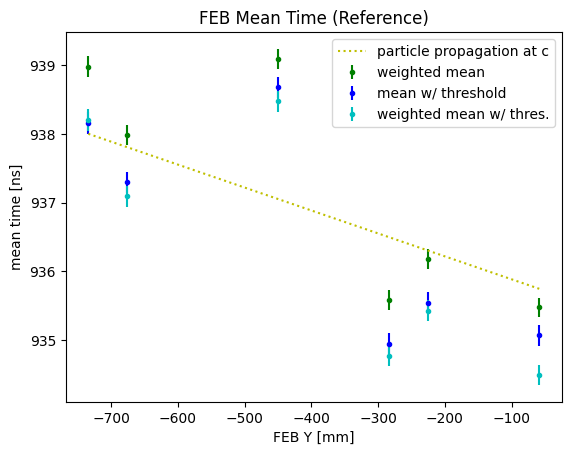

In [8]:
fig,ax = plt.subplots()
#plt.errorbar(FEB_Y, ref_mean_1, yerr=ref_mean_1_err, fmt='.', c='r', label='mean')
plt.errorbar(FEB_Y, ref_mean_2, yerr=ref_mean_2_err, fmt='.', c='g', label='weighted mean')
plt.errorbar(FEB_Y, ref_mean_3, yerr=ref_mean_3_err, fmt='.', c='b', label='mean w/ threshold')
plt.errorbar(FEB_Y, ref_mean_4, yerr=ref_mean_4_err, fmt='.', c='c', label='weighted mean w/ thres.')

# add stright line of -1ns/300mm
print('FEB mean Y position span =', max(FEB_Y)-min(FEB_Y))
xlist = [min(FEB_Y), max(FEB_Y)]
ylidt = [938., 938.-(max(FEB_Y)-min(FEB_Y))/300.]
plt.plot(xlist, ylidt, color='y', linestyle='dotted', label='particle propagation at c')

plt.title('FEB Mean Time (Reference)')
plt.xlabel('FEB Y [mm]')
plt.ylabel('mean time [ns]')
plt.legend()
plt.show()

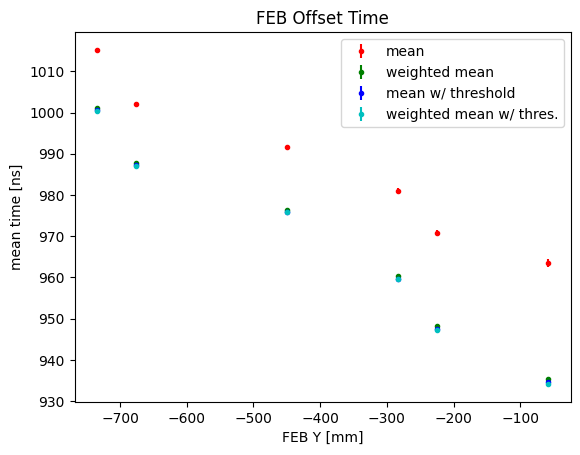

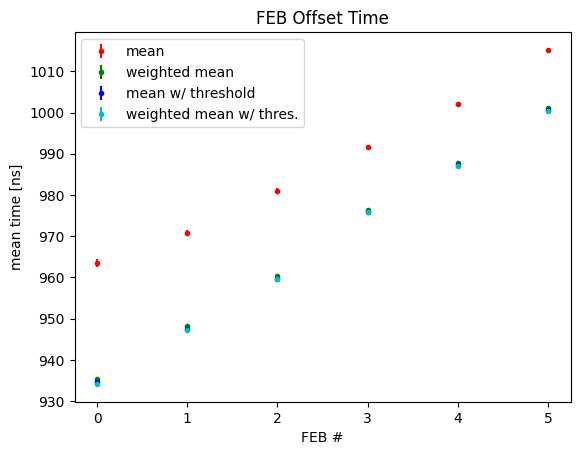

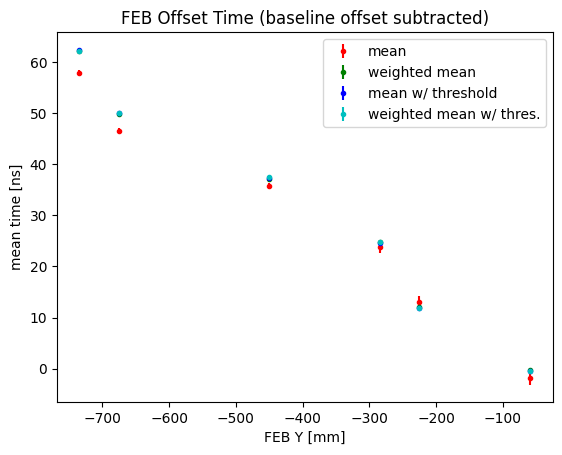

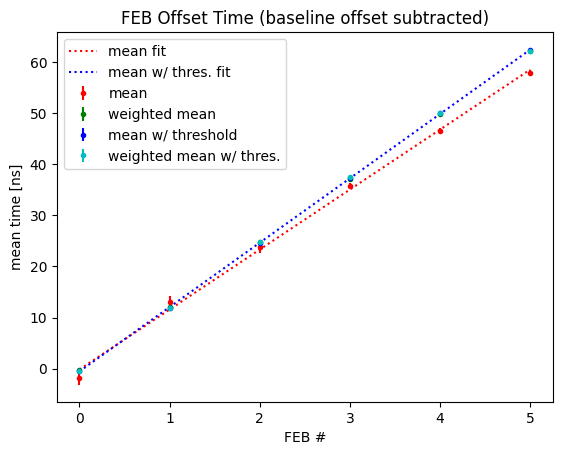

red : 11.743*x+-0.162
blue: 12.600*x+-0.539
[0.09706132018701363, -0.14627362018060808, -0.013707635236276161, -0.032265979630643926, 0.20544274430189802, -0.11025682980071139]
set offset = 12.56 ns


In [9]:
fig,ax = plt.subplots()
plt.errorbar(FEB_Y, offset_mean_1, yerr=offset_mean_1_err, fmt='.', c='r', label='mean')
plt.errorbar(FEB_Y, offset_mean_2, yerr=offset_mean_2_err, fmt='.', c='g', label='weighted mean')
plt.errorbar(FEB_Y, offset_mean_3, yerr=offset_mean_3_err, fmt='.', c='b', label='mean w/ threshold')
plt.errorbar(FEB_Y, offset_mean_4, yerr=offset_mean_4_err, fmt='.', c='c', label='weighted mean w/ thres.')
plt.title('FEB Offset Time')
plt.xlabel('FEB Y [mm]')
plt.ylabel('mean time [ns]')
plt.legend()
plt.show()

FEBNum = np.array([i for i in range(6)])
fig,ax = plt.subplots()
plt.errorbar(FEBNum, offset_mean_1, yerr=offset_mean_1_err, fmt='.', c='r', label='mean')
plt.errorbar(FEBNum, offset_mean_2, yerr=offset_mean_2_err, fmt='.', c='g', label='weighted mean')
plt.errorbar(FEBNum, offset_mean_3, yerr=offset_mean_3_err, fmt='.', c='b', label='mean w/ threshold')
plt.errorbar(FEBNum, offset_mean_4, yerr=offset_mean_4_err, fmt='.', c='c', label='weighted mean w/ thres.')
plt.title('FEB Offset Time')
plt.xlabel('FEB #')
plt.ylabel('mean time [ns]')
plt.legend()
plt.show()

fig,ax = plt.subplots()
plt.errorbar(FEB_Y, offset_mean_1-ref_mean_1, yerr=np.sqrt(ref_mean_1_err**2+offset_mean_1_err**2), fmt='.', c='r', label='mean')
plt.errorbar(FEB_Y, offset_mean_2-ref_mean_2, yerr=np.sqrt(ref_mean_2_err**2+offset_mean_2_err**2), fmt='.', c='g', label='weighted mean')
plt.errorbar(FEB_Y, offset_mean_3-ref_mean_3, yerr=np.sqrt(ref_mean_3_err**2+offset_mean_3_err**2), fmt='.', c='b', label='mean w/ threshold')
plt.errorbar(FEB_Y, offset_mean_4-ref_mean_4, yerr=np.sqrt(ref_mean_4_err**2+offset_mean_4_err**2), fmt='.', c='c', label='weighted mean w/ thres.')
plt.title('FEB Offset Time (baseline offset subtracted)')
plt.xlabel('FEB Y [mm]')
plt.ylabel('mean time [ns]')
plt.legend()
plt.show()

def func(x,a,b):
    return a*x+b

fig,ax = plt.subplots()
plt.errorbar(FEBNum, offset_mean_1-ref_mean_1, yerr=np.sqrt(ref_mean_1_err**2+offset_mean_1_err**2), fmt='.', c='r', label='mean')
plt.errorbar(FEBNum, offset_mean_2-ref_mean_2, yerr=np.sqrt(ref_mean_2_err**2+offset_mean_2_err**2), fmt='.', c='g', label='weighted mean')
plt.errorbar(FEBNum, offset_mean_3-ref_mean_3, yerr=np.sqrt(ref_mean_3_err**2+offset_mean_3_err**2), fmt='.', c='b', label='mean w/ threshold')
plt.errorbar(FEBNum, offset_mean_4-ref_mean_4, yerr=np.sqrt(ref_mean_4_err**2+offset_mean_4_err**2), fmt='.', c='c', label='weighted mean w/ thres.')
plt.title('FEB Offset Time (baseline offset subtracted)')
plt.xlabel('FEB #')
plt.ylabel('mean time [ns]')
optimizedParameters1, pcov1 = opt.curve_fit(func, FEBNum, offset_mean_1-ref_mean_1)
plt.plot(FEBNum, func(FEBNum, *optimizedParameters1), c='r', label='mean fit',  linestyle='dotted')
optimizedParameters3, pcov3 = opt.curve_fit(func, FEBNum, offset_mean_3-ref_mean_3)
plt.plot(FEBNum, func(FEBNum, *optimizedParameters3), c='b', label='mean w/ thres. fit',  linestyle='dotted')
plt.legend()
plt.show()

residue = [offset_mean_3[i]-ref_mean_3[i]-func(FEBNum[i], optimizedParameters3[0],optimizedParameters3[1]) for i in range(len(FEBNum))]

print ("red : %.3f*x+%.3f"%(optimizedParameters1[0],optimizedParameters1[1]))
print ("blue: %.3f*x+%.3f"%(optimizedParameters3[0],optimizedParameters3[1]))
print (residue)
print ("set offset = 12.56 ns")

In [10]:
from __future__ import print_function
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

import ROOT
%jsroot on
# from ROOT import TCanvas, TH1F, TH2F, TF1, TMath, TGraph, TFile, TSpectrum, TPaveText, TMultiGraph, TGraphErrors, TLine
from ROOT import gStyle, gROOT, gDirectory, gPad

import constants
import crv_event
import crv_spill
import utils
import geometry
import geometry_constants
import filepath

gROOT.Reset()
gROOT.SetBatch(1)
gROOT.ProcessLine( "gErrorIgnoreLevel = 1001;")
gStyle.SetOptStat(111110)
gStyle.SetOptFit(0)
gStyle.SetLineScalePS(0.3)

tgeometry = geometry.testBenchGeometry(geometry_constants.setup_dict['crvaging-006'][0])

refFileList = filepath.getfilelist(["1379"])[0]

tmin = -35.
tmax = 35.
nbin = 350
singleFEBshowerthres = 300
singleChThres = 6

def timeDiff(filelist):
    hist_diffpercounter = [[None]*32 for i in range(6)] # time difference between two channels in a counter
    hist_diffbtwlayerinfeb = [[None]*15 for i in range(6)] # time difference between two neighboring (vertical) counters in the same FEB
    hist_diffbtwfeb = [[None]*15 for i in range(2)] # time difference between two neighboring (vertical) counters in different FEBs (0 & 1, then 4 & 5)
    
    for i in range(6):
        for j in range(32):
            hist_diffpercounter[i][j] = ROOT.TH1F("hist_diffpercounter_feb%i_cntr%i"%(i,j), 
                                                  "Time difference between FEB%i Ch%i and Ch%i (same counter/CMB); t_{diff} [ns]; count"%(i, 2*j, 2*j+1), 
                                                  nbin, tmin, tmax)
    
    ch_btwlayerinfeb_list = [(2+2*i, 32+2*i) for i in range(15)]
    for i in range(6):
        for j in range(15):
            hist_diffbtwlayerinfeb[i][j] = ROOT.TH1F("hist_diffbtwlayerinfeb_feb%i_cntr%i"%(i,j), 
                                                     "Time difference between FEB%i Ch%i and Ch%i (neighboring layer); t_{diff} [ns]; count"%(i, ch_btwlayerinfeb_list[j][0], ch_btwlayerinfeb_list[j][1]), 
                                                     nbin, tmin, tmax)
    
    ch_btwfeb_list = [[(1, 34+2*i, 2, 2*i) for i in range(15)], [(4, 34+2*i, 5, 2*i) for i in range(15)]]
    for i in range(2):
        for j in range(15):
            hist_diffbtwfeb[i][j] = ROOT.TH1F("hist_diffbtwfeb_%i_%i"%(i,j), 
                                              "Time difference between FEB%i Ch%i and FEB%i Ch%i (neighboring layer); t_{diff} [ns]; count"%ch_btwfeb_list[i][j], 
                                              nbin, tmin, tmax)

    for filename in filelist:
        print("Processing file %s"%(filename.split('/')[-1]))
        fFile = ROOT.TFile(filename, "READ")
        fTree = fFile.Get("run")
        nEntries = fTree.GetEntries()
        for iEntry in range(nEntries):
            if iEntry % 10000 == 0:            
                print("processed %i/%i entries..."%(iEntry, nEntries))            
            tEvent = crv_event.crv_event(fTree, iEntry, 0b1010, 6)
            tgoodhitPE = [tEvent.PEsTemperatureCorrected[i][tEvent.fitStatus[i]==1] for i in range(6)]
            if np.all(np.array([np.sum(tgoodhitPE[i]) for i in range(6)])<singleFEBshowerthres): # only look at more muonic events
                
                for i in range(6):
                    for j in range(32):
                        if tEvent.fitStatus[i][2*j]==1 and tEvent.fitStatus[i][2*j+1]==1 and tEvent.PEsTemperatureCorrected[i][2*j]>singleChThres and tEvent.PEsTemperatureCorrected[i][2*j+1]>singleChThres:
                            hist_diffpercounter[i][j].Fill(tEvent.time[i][2*j]-tEvent.time[i][2*j+1])
                
                for i in range(6):
                    for j in range(15):
                        ch0, ch1 = ch_btwlayerinfeb_list[j]
                        if tEvent.fitStatus[i][ch0]==1 and tEvent.fitStatus[i][ch1]==1 and tEvent.PEsTemperatureCorrected[i][ch0]>singleChThres and tEvent.PEsTemperatureCorrected[i][ch1]>singleChThres:
                            hist_diffbtwlayerinfeb[i][j].Fill(tEvent.time[i][ch0]-tEvent.time[i][ch1])
                
                for i in range(2):
                    for j in range(15):
                        feb0, ch0, feb1, ch1 = ch_btwfeb_list[i][j]
                        if tEvent.fitStatus[feb0][ch0]==1 and tEvent.fitStatus[feb1][ch1]==1 and tEvent.PEsTemperatureCorrected[feb0][ch0]>singleChThres and tEvent.PEsTemperatureCorrected[feb1][ch1]>singleChThres:
                            hist_diffbtwfeb[i][j].Fill(tEvent.time[feb0][ch0]-tEvent.time[feb1][ch1])

        fFile.Close()
    return hist_diffpercounter, hist_diffbtwlayerinfeb, hist_diffbtwfeb

hist_diffpercounter, hist_diffbtwlayerinfeb, hist_diffbtwfeb = timeDiff(refFileList)

Welcome to JupyROOT 6.28/04
Processing file rec.mu2e.CRV_wideband_cosmics.CRVWB-000-001-000.001379_000.root
processed 0/230513 entries...
processed 10000/230513 entries...
processed 20000/230513 entries...
processed 30000/230513 entries...
processed 40000/230513 entries...
processed 50000/230513 entries...
processed 60000/230513 entries...
processed 70000/230513 entries...
processed 80000/230513 entries...
processed 90000/230513 entries...
processed 100000/230513 entries...
processed 110000/230513 entries...
processed 120000/230513 entries...
processed 130000/230513 entries...
processed 140000/230513 entries...
processed 150000/230513 entries...
processed 160000/230513 entries...
processed 170000/230513 entries...
processed 180000/230513 entries...
processed 190000/230513 entries...
processed 200000/230513 entries...
processed 210000/230513 entries...
processed 220000/230513 entries...
processed 230000/230513 entries...


In [11]:
c05 = ROOT.TCanvas("c05", "c05", 640*2, 360*96)
c05.Divide(2, 96, 0.001, 0.001)
for i in range(6):
    for j in range(32):
        c05.cd(i*32+j+1)
        hist_diffpercounter[i][j].Draw()
c05.Draw()

Text(0, 0.5, 'counts')

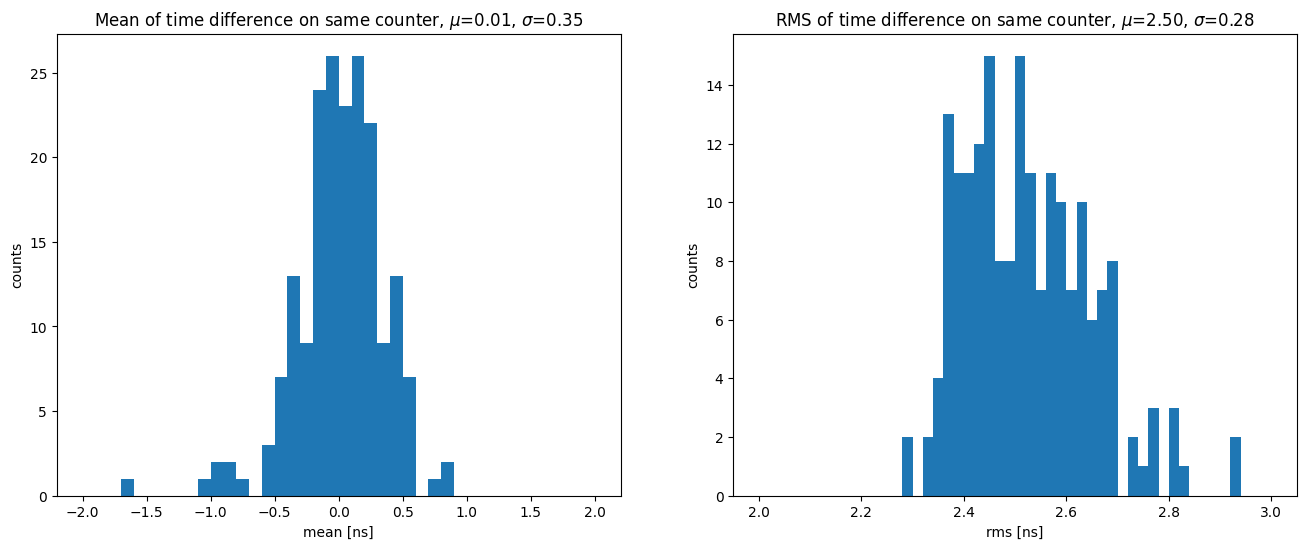

In [17]:
histmean = np.array([[hist_diffpercounter[i][j].GetMean() for j in range(32)]for i in range(6)]).flatten()
histrms = np.array([[hist_diffpercounter[i][j].GetStdDev() for j in range(32)]for i in range(6)]).flatten()
fig, axes = plt.subplots(1,2,figsize=(16,6))
axes[0].hist(histmean, [-2.+0.1*i for i in range(40+1)])
axes[0].set_title("Mean of time difference on same counter, "+r'$\mu$'+"=%.2f"%(np.mean(histmean))+r', $\sigma$'+"=%.2f"%(np.std(histmean)))
axes[0].set_xlabel("mean [ns]")
axes[0].set_ylabel("counts")
axes[1].hist(histrms, [2.+0.02*i for i in range(50+1)])
axes[1].set_title("RMS of time difference on same counter, "+r'$\mu$'+"=%.2f"%(np.mean(histrms))+r', $\sigma$'+"=%.2f"%(np.std(histrms)))
axes[1].set_xlabel("rms [ns]")
axes[1].set_ylabel("counts")

Module 162 has 1.4 mm fiber, different than the others.

Text(0, 0.5, 'counts')

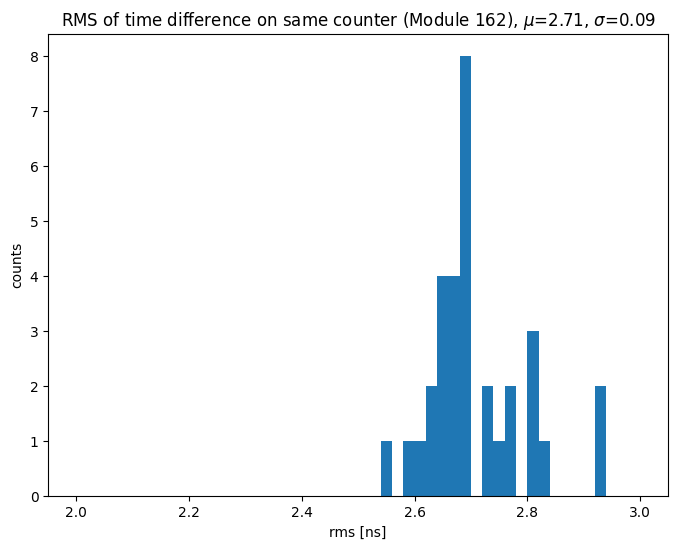

In [18]:
histrms162 = np.array([hist_diffpercounter[0][j].GetStdDev() for j in range(32)])
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(histrms162, [2.+0.02*i for i in range(50+1)])
ax.set_title("RMS of time difference on same counter (Module 162), "+r'$\mu$'+"=%.2f"%(np.mean(histrms162))+r', $\sigma$'+"=%.2f"%(np.std(histrms162)))
ax.set_xlabel("rms [ns]")
ax.set_ylabel("counts")

In [14]:
c06 = ROOT.TCanvas("c06", "c06", 640*2, 360*48)
c06.Divide(2, 48, 0.001, 0.001)
for i in range(6):
    for j in range(15):
        c06.cd(i*16+j+1)
        hist_diffbtwlayerinfeb[i][j].Draw()
c06.Draw()

In [15]:
c07 = ROOT.TCanvas("c07", "c07", 640*2, 360*16)
c07.Divide(2, 16, 0.001, 0.001)
for i in range(2):
    for j in range(15):
        c07.cd(i*16+j+1)
        hist_diffbtwfeb[i][j].Draw()
c07.Draw()

1. The phase alignment steps in the setup do seem to fix most of the double peak problem we saw, except on FEB5.
2. Timing resolution is back at 1.7 ns. Difference between module 127 and 168? CRV_L vs CRV_T?